<a href="https://colab.research.google.com/github/ChengyangHuang/Personalized_Regression/blob/main/Academic_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

if not os.path.exists("/content/student.zip"):
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
if not (os.path.exists("/content/student-por.csv") and os.path.exists("/content/student-por.csv")):
    !unzip /content/student.zip

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

from scipy.spatial import KDTree
from scipy.spatial import distance_matrix
from scipy.special import softmax, expit

import torch

# np.random.seed(0)


def make_mapping(column):
    mapping = {}
    for x in column:
        if not (x in mapping.keys()):
            mapping[x] = len(mapping)
    return mapping


def load_dataset(filepath = "/content/student-por.csv"):
    dataset = pd.read_csv(filepath, sep=';')
    print(dataset)
    mapping_dict = {}
    yn_mapping = {"yes": 1, 
                "no": 0}

    X = []
    for name, column in dataset.items():
        column = column.values
        if type(column[0]) == str:
            if column[0] == "yes" or column[0] == "no":
                mapping_dict[name] = yn_mapping
                X.append([yn_mapping[x] for x in column])
            elif name == "Fjob":
                mapping = mapping_dict["Mjob"]
                mapping_dict[name] = mapping
                X.append([mapping[x] for x in column])
            else:
                mapping = make_mapping(column)
                mapping_dict[name] = mapping
                X.append([mapping[x] for x in column])
        else:
            X.append(column)
    
    X = np.array(X).T
    y = X[:, -3:]
    X = X[:, :-3]
    return X, y


def print_metrics(dic):
    message = f"\n"
    for k, v in dic.items():
        message += f"{k}:\t{v}\n"
    print(message)


def evaluate_method(method, X_test, y_test, method_name, U_test=None):
    if method_name == "Personalized Regression":
        y_pred = method.predict(X_test, U_test)
    else:
        y_pred = method.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    performance_dict = {"method_name": method_name,
                        "MSE": mse,
                        "R2": R2
                        }
    return performance_dict

In [ ]:
class PRRegressor():
    def __init__(self, args, theta_pop, trainset, validset=None):
        # Training Parameters
        self.cov_norm_ord = args.covariate_norm_ord
        self.cov_xstart = args.covariate_x_start
        self.cov_xend= args.covariate_x_end
        self.sigma_theta = args.sigma_theta
        self.lambd = args.theta_regularizer
        self.gamma = args.distance_regularizer
        self.nu = args.phi_regularizer
        self.alpha = args.learning_rate
        self.c = args.lr_decay
        self.q = args.latent_dim
        self.k = args.covariate_dim
        self.log_steps = args.log_steps
        self.n_neighbors = args.n_neighbors
        self.show_logs = args.show_logs
        self.use_distance_loss = args.use_distance_loss

        self.theta_pop = torch.from_numpy(theta_pop).flatten()
        self.n_features, self.n_outputs = theta_pop.shape

        # Training Data
        X_train, y_train, U_train = trainset
        self.X_train = torch.from_numpy(X_train)
        self.y_train = torch.from_numpy(y_train).to(dtype=torch.double)
        self.__init_U_train(U_train)
        self.n = self.X_train.shape[0]

        # Validation Data
        if type(validset) != "NoneType":
            self.eval = True
            self.X_eval, self.y_eval, self.U_eval = validset
        else: 
            self.eval = False

        # Variable Initialization
        PI = np.random.multivariate_normal(theta_pop.flatten(), self.sigma_theta*np.eye(self.n_features*self.n_outputs), size=self.n)
        self.PI = torch.from_numpy(PI)
        self.Z, self.Q = self.__init_ZnQ(PI)
        self.phi = torch.ones((self.k, ), dtype=torch.float64) / self.k

        # Loss Functions
        self.__sample_specific_loss = torch.nn.MSELoss(reduction="mean")
        self.__parameter_regularizer = torch.nn.L1Loss()
        self.__phi_regularizer = torch.nn.MSELoss()
        self.__distance_loss = torch.nn.MSELoss()


    def train(self, n_epoch=5):
        for epoch in range(n_epoch):
            # Require Gradient for variables
            Z = self.Z.clone().requires_grad_(True)
            Q = self.Q.clone().requires_grad_(True)
            phi = self.phi.clone().requires_grad_(True)
            PI = self.__update_PI(Z, Q) 

            y_pred = self.__predict(self.X_train, PI)

            # Calculate Loss
            l_loss = self.__sample_specific_loss(y_pred, self.y_train)
            D_loss = self.__distance_matching_regularizer(Z, phi) if self.use_distance_loss else 0
            theta_loss = self.__parameter_regularizer(PI, torch.zeros_like(PI))
            phi_sum = torch.sum(phi, dim=0, keepdim=True)
            phi_loss = self.__phi_regularizer(phi_sum, torch.ones_like(phi_sum)) # Weight should sum to one
            loss = l_loss + self.gamma * D_loss + self.lambd * theta_loss + self.nu * phi_loss
            
            # Update phi
            loss.backward()
            self.phi -= self.alpha * phi.grad

            # Update Z
            alpha_cust = self.alpha / torch.linalg.norm(self.PI-self.theta_pop, 
                                                        float('inf'), dim=1, keepdim=True)

            # self.Z -= alpha_cust * Z.grad
            self.Z -= torch.bmm(Z.grad.unsqueeze(2), alpha_cust.unsqueeze(2)).squeeze()

            # Update Q
            self.Q -= self.alpha * Q.grad

            # Update alpha
            self.alpha *= self.c

            # Update theta, PI
            self.PI = self.__update_PI(self.Z, self.Q)

            if self.show_logs and epoch % self.log_steps == 0:
                message = f"Epoch {epoch+1} - Total loss: {loss}\tDistance loss:{D_loss}"
                print("-"*20)
                print(message)
                if self.eval:
                    print_metrics(evaluate_method(self, self.X_eval, self.y_eval, "Personalized Regression", self.U_eval))
                print("-"*20)
        

    def predict(self, X_test, U_test):
        X = torch.from_numpy(X_test)
        dist_mat_test = self.__create_distance_matrix(self.U_train.numpy(), U_test)
        _, idx_sets = torch.matmul(dist_mat_test, self.phi).topk(self.n_neighbors, dim=1)
        PI = self.PI[idx_sets, :].mean(axis=1)
        y_pred = self.__predict(X, PI).detach().numpy()
        return y_pred


    def __predict(self, X, PI):
        pred = torch.bmm(X.unsqueeze(1), PI.view(-1, self.n_features, self.n_outputs)).squeeze()
        return pred

    def __create_distance_matrix(self, A, B):
        dist_mat = []
        for i in range(self.k):
            dist_mat.append(distance_matrix(A[:, [i]], B[:, [i]], p=self.cov_norm_ord))
        dist_mat = torch.from_numpy(np.array(dist_mat)).T
        return dist_mat

    def __init_U_train(self, U_train: np.array):
        self.U_train = torch.from_numpy(U_train)
        self.U_distance_mat = self.__create_distance_matrix(U_train, U_train)
        # print(f"Distance Matrix Shape: {self.U_distance_mat.shape}")


    def __init_ZnQ(self, PI):
        pca = PCA(n_components=self.q, whiten=False)
        Z = pca.fit_transform(PI)
        Q = pca.components_
        return torch.from_numpy(Z), torch.from_numpy(Q)
    

    def __update_PI(self, Z, Q):
        return torch.mm(Z, Q) + self.theta_pop
    

    def __distance_matching_regularizer(self, Z, phi):       
        _Z = Z.detach().numpy()
        tree = KDTree(_Z)
        _, idx_set = tree.query(_Z, k=6)
        idx_set = idx_set[:, 1:]
        Z_set = Z[idx_set, :]
        delta_Z = Z.view(Z.shape[0], 1, -1).expand(-1, Z_set.shape[1], -1) - Z_set
        delta_Z = torch.linalg.norm(delta_Z, ord=2, dim=2)

        U_dist_idx = torch.from_numpy(idx_set).to(dtype=torch.int64).view(idx_set.shape[0], -1, 1).expand(-1, -1, self.k)
        U_dist_set = torch.gather(self.U_distance_mat, 1, U_dist_idx)
        rho_U = torch.matmul(U_dist_set, phi)
        d_loss = self.__distance_loss(delta_Z, rho_U)
        return d_loss


    school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0       GP   F   18       U     GT3       A  ...     1       3        4   0  11  11
1       GP   F   17       U     GT3       T  ...     1       3        2   9  11  11
2       GP   F   15       U     LE3       T  ...     3       3        6  12  13  12
3       GP   F   15       U     GT3       T  ...     1       5        0  14  14  14
4       GP   F   16       U     GT3       T  ...     2       5        0  11  13  13
..     ...  ..  ...     ...     ...     ...  ...   ...     ...      ...  ..  ..  ..
644     MS   F   19       R     GT3       T  ...     2       5        4  10  11  10
645     MS   F   18       U     LE3       T  ...     1       1        4  15  15  16
646     MS   F   18       U     GT3       T  ...     1       5        6  11  12   9
647     MS   M   17       U     LE3       T  ...     4       2        6  10  10  10
648     MS   M   18       R     LE3       T  ...     4       5        4  10 

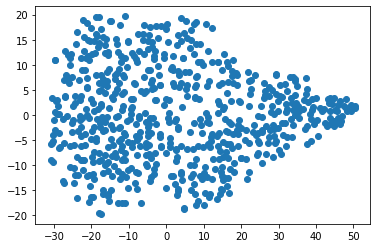

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1 - Total loss: 14.64652627952575	Distance loss:0

method_name:	Personalized Regression
MSE:	7.822353998083331
R2:	0.25768043595972556

--------------------
--------------------
Epoch 101 - Total loss: 12.94558140035771	Distance loss:0

method_name:	Personalized Regression
MSE:	7.927129024317691
R2:	0.24773757837291022

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 201 - Total loss: 11.551554595041178	Distance loss:0

method_name:	Personalized Regression
MSE:	8.485672361282438
R2:	0.1947333744600135

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 301 - Total loss: 10.817067471268023	Distance loss:0

method_name:	Personalized Regression
MSE:	9.673911183167988
R2:	0.08197282636235204

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 401 - Total loss: 10.516019954713338	Distance loss:0

method_name:	Personalized Regression
MSE:	10.293128010319654
R2:	0.023210877556371856

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 501 - Total loss: 10.406798128791811	Distance loss:0

method_name:	Personalized Regression
MSE:	10.574484483298477
R2:	-0.0034890665285831624

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 601 - Total loss: 10.363670227371886	Distance loss:0

method_name:	Personalized Regression
MSE:	10.707121220809471
R2:	-0.016075922759969608

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 701 - Total loss: 10.345953087848404	Distance loss:0

method_name:	Personalized Regression
MSE:	10.770491708728628
R2:	-0.022089605211146557

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 801 - Total loss: 10.339842780397598	Distance loss:0

method_name:	Personalized Regression
MSE:	10.798105533831722
R2:	-0.024710080149641378

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 901 - Total loss: 10.337320462592087	Distance loss:0

method_name:	Personalized Regression
MSE:	10.808371246150195
R2:	-0.02568426759943976

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1001 - Total loss: 10.3361393479905	Distance loss:0

method_name:	Personalized Regression
MSE:	10.810914641952019
R2:	-0.025925628763004305

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1101 - Total loss: 10.335558417499943	Distance loss:0

method_name:	Personalized Regression
MSE:	10.810016282809825
R2:	-0.025840376987522395

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1201 - Total loss: 10.335261911546457	Distance loss:0

method_name:	Personalized Regression
MSE:	10.807751368050585
R2:	-0.02562544289772295

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1301 - Total loss: 10.335106089002577	Distance loss:0

method_name:	Personalized Regression
MSE:	10.805129516005954
R2:	-0.02537663645566912

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1401 - Total loss: 10.335022184202499	Distance loss:0

method_name:	Personalized Regression
MSE:	10.802617291423237
R2:	-0.02513823335380616

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1501 - Total loss: 10.334976041460333	Distance loss:0

method_name:	Personalized Regression
MSE:	10.800403962180788
R2:	-0.024928194585586816

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1601 - Total loss: 10.334950188629037	Distance loss:0

method_name:	Personalized Regression
MSE:	10.798541146256786
R2:	-0.024751418553086824

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1701 - Total loss: 10.334935462751332	Distance loss:0

method_name:	Personalized Regression
MSE:	10.797015941263295
R2:	-0.02460668085569817

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1801 - Total loss: 10.334926952217154	Distance loss:0

method_name:	Personalized Regression
MSE:	10.795788861882626
R2:	-0.024490234446967074

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 1901 - Total loss: 10.334921971089834	Distance loss:0

method_name:	Personalized Regression
MSE:	10.794812883422352
R2:	-0.02439761681481678

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2001 - Total loss: 10.334919023520312	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79404244219376
R2:	-0.024324504092346322

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2101 - Total loss: 10.334917262671743	Distance loss:0

method_name:	Personalized Regression
MSE:	10.793437196048204
R2:	-0.024267067922234986

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2201 - Total loss: 10.334916202078533	Distance loss:0

method_name:	Personalized Regression
MSE:	10.792963131358155
R2:	-0.02422208050615393

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2301 - Total loss: 10.33491555867502	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79259240452617
R2:	-0.024186899564411224

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2401 - Total loss: 10.334915165891564	Distance loss:0

method_name:	Personalized Regression
MSE:	10.792302649962703
R2:	-0.024159402664976293

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2501 - Total loss: 10.334914924751352	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79207612080117
R2:	-0.02413790567973706

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2601 - Total loss: 10.334914775937586	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791898878776534
R2:	-0.024121085906240625

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2701 - Total loss: 10.334914683643701	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791760008352504
R2:	-0.02410790749055547

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2801 - Total loss: 10.334914626115504	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79165100251315
R2:	-0.024097563140610845

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 2901 - Total loss: 10.334914590062262	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791565246461143
R2:	-0.024089425130600528

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3001 - Total loss: 10.334914567324038	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791497602241602
R2:	-0.02408300588294532

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3101 - Total loss: 10.334914552869193	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791444080272854
R2:	-0.024077926797478444

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3201 - Total loss: 10.33491454358308	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791401581922354
R2:	-0.024073893822619263

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3301 - Total loss: 10.334914537531024	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791367698959228
R2:	-0.02407067842397792

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3401 - Total loss: 10.334914533507538	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79134055793504
R2:	-0.024068102816526826

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3501 - Total loss: 10.33491453075938	Distance loss:0

method_name:	Personalized Regression
MSE:	10.79131869972673
R2:	-0.024066028533559658

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3601 - Total loss: 10.334914528814677	Distance loss:0

method_name:	Personalized Regression
MSE:	10.7913009864229
R2:	-0.024064347590459834

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3701 - Total loss: 10.334914527377126	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791286529382418
R2:	-0.024062975657664243

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3801 - Total loss: 10.334914526260267	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791274633642455
R2:	-0.024061846785140117

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 3901 - Total loss: 10.334914525346532	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791264754932786
R2:	-0.024060909323161628

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4001 - Total loss: 10.334914524561654	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791256466404144
R2:	-0.024060122764924863

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4101 - Total loss: 10.334914523858638	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791249432842612
R2:	-0.024059455299564547

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4201 - Total loss: 10.334914523207695	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791243390656653
R2:	-0.024058881912979224

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4301 - Total loss: 10.334914522589925	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791238132320062
R2:	-0.024058382911511744

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4401 - Total loss: 10.334914521993309	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791233494258895
R2:	-0.02405794277245077

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4501 - Total loss: 10.334914521410198	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791229347404327
R2:	-0.024057549247525234

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4601 - Total loss: 10.334914520835719	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791225589812687
R2:	-0.024057192662565008

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4701 - Total loss: 10.334914520266768	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791222140890891
R2:	-0.024056865369511682

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4801 - Total loss: 10.334914519701352	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791218936871193
R2:	-0.024056561316984082

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------
Epoch 4901 - Total loss: 10.334914519138204	Distance loss:0

method_name:	Personalized Regression
MSE:	10.791215927259667
R2:	-0.02405627571324942

--------------------


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([434, 1])) that is different to the input size (torch.Size([434])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



method_name:	Linear Regression
MSE:	7.843097335056123
R2:	0.25571195117085554


method_name:	Personalized Regression
MSE:	10.791213099942992
R2:	-0.024056007408787217



In [ ]:
class PR_Arguments():
    # Data Arguments
    sigma_theta = 0.01 #0.001
    theta_regularizer = 0.01
    distance_regularizer = 0.01
    phi_regularizer = 0

    # 
    n_neighbors = 3
    latent_dim = 2
    covariate_dim = 2
    covariate_norm_ord = 2
    covariate_x_start = 2
    covariate_x_end = -1

    # Traing Arguments
    learning_rate = 0.001 #4e-3
    lr_decay = 1 #1-1e-4
    n_epoch = 5000 #2000
    log_steps = 100
    show_logs = True
    use_distance_loss = False


def main():
    X, y = load_dataset()
    y = y[:, [-1]]
    print(y.shape)
    U = TSNE().fit_transform(X[:, 2:])
    plt.scatter(U[:, 0], U[:, 1])
    plt.show()
    X_train, X_test, y_train, y_test, U_train, U_test = train_test_split(X, y, U, test_size=0.33, random_state=42)

    ## Preprocessing
    # scaler =  StandardScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    ### Methods
    dict_list = []

    ## Linear Regression
    lr = LinearRegression().fit(X_train, y_train)
    dict_lr = evaluate_method(lr, X_test, y_test, "Linear Regression")
    dict_list.append(dict_lr)

    ## Gaussian Mixture
    # gmm = GaussianMixture(n_components=3).fit(X_train, y_train)
    # dict_gmm = evaluate_method(gmm, X_test, y_test, "Gaussian Mixture")
    # dict_list.append(dict_gmm)

    # ## DNN
    # dnn = MLPRegressor(hidden_layer_sizes=(100,)).fit(X_train, y_train.squeeze())
    # dict_dnn = evaluate_method(dnn, X_test, y_test, "Deep Neural Networks")
    # dict_list.append(dict_dnn)


    # ## Personalized Regression
    pr_args = PR_Arguments()
    theta_lr = np.concatenate((np.array(lr.coef_), np.array(lr.intercept_).reshape((-1, 1))), axis=1).T
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)
    trainset = (X_train, y_train, U_train)
    evalset = (X_test, y_test, U_test)
    pr = PRRegressor(pr_args, theta_lr, trainset, evalset)
    pr.train(pr_args.n_epoch)
    dict_pr = evaluate_method(pr, X_test, y_test, "Personalized Regression", U_test)
    dict_list.append(dict_pr) 

    for x in dict_list:
        print_metrics(x)


if __name__ == "__main__":
    main()